## Prediction of Tennis Match Results using K-Nearest Neighbours Classification Model

## Introduction

ATP (Association of Tennis Professionals) and WTA (Women's Tennis Association) rankings are based on the points earned by players in ATP or WTA-certified events over the preceding 52-weeks. Each player or team has a maximum of one bounce after the ball has been hit by their opponent to return the ball over the net and within the boundaries of the court. When a player then fails to return the ball into the correct court, the opponent wins a point. The aim of tennis is to win enough points to win a game, enough games to win a set, and enough sets to win a match. Each tennis match includes best-of-three tiebreak sets and each set has at least 6 games. Whoever starts serving continues to serve until that game is over. Games are scored starting from 0 to 40, then game point, which wins the game (United States Tennis Association, n.d.).

Our project will predict whether a professional tennis player will win or lose the match based on age, rank, and first-serve points won. The dataset we are using contains 8614 rows of data from tennis matches for top 500 players from 2017 to 2019 (Sackmann, 2020). The dataset includes the tournament's ID, name, level, date and draw size, and the match number, score and time. Also has winners and losers ID, seed, name, age, height, hand used, country, rank, rank points, and their aces, serve points, break points faced and saved in the match. Age of players is calculated when they’re in the match and reported in decimals. Rank is based on the player’s ATP/WTA rank as of the tournament date. First-serve points won are recorded directly from the match listed in this dataset. We chose age as a parameter since age can reflect a player's athletic performance with their strength, flexibility and the ability of recovering from injuries (Costello, 2020). Meanwhile, rank is used since it is based on previous match points and reflects a player's skills by previous match performances. Lastly, first-serve points won may affect player’s mentality, as for players getting more first-serve points might be less tense, and results in better performance (Mirpuri, 2021).

## Methods & Results

We will conduct our data analysis by building a binary classification model with K-nearest neighbours algorithm using the training dataset. For classification, prediction of observations without a known class (i.e. player in a new match or match in progress) to a class (i.e., win or lose) will be based on a majority vote of the closest neighbouring classes. The best number of neighbours, or best value of K will be determined by tuning. 

We start by loading the “tidyverse” package needed for our analysis, and loading the “tidymodels” package to help make and use the classifier and also to keep our code simple, readable and accurate.

In [12]:
library(tidyverse)
library(tidymodels)
library(cowplot)

Our first step is to read, wrangle, and explore the data using visualizations in order to better understand the data we are working with. 

Our data of ATP matches of 2017, 2018, and 2019 are read from the web separately for each year, then combined into one dataset with match data from all three years. We will select the data columns with winners’ and losers’ age, rank, and 1stWon (first-serve points won) in the match as the variables for prediction. We will omit all rows with n/a after selecting our predictors to remove all incomplete records from our analysis and ensure missing data does not disrupt our analysis. 

Then, the data is wrangled so that the age of both winner and loser of the match are combined into one column, and the same is done for rank and first-serve points won. Thus, the “result” column can be created and since we will be working with “result” as a categorical statistical variable, we will convert it to a factor.

The seed is set, so the wrangled dataset is split randomly, but reproducibly, to create a training set (75% of original dataset) and testing set (25% of original dataset) with strata argument as the categorical label variable “result”. 


In [3]:
set.seed(123)

# Reading and Wrangling Data

data_2017 <- read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2017.csv")
data_2018 <- read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2018.csv")
data_2019 <- read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2019.csv")


atp_data <- rbind(data_2017,data_2018,data_2019) |>
  select(winner_age, loser_age, winner_rank, loser_rank, w_1stWon, l_1stWon) |> 
  na.omit()

win <- rep(c("win"), times = nrow(atp_data))
atp_data_win <- cbind(atp_data, win) |>
  select(win, winner_age, winner_rank, w_1stWon)
colnames(atp_data_win) <- c("result", "age","rank", "first_svpt_won")

lose <- rep(c("lose"), times = nrow(atp_data))
atp_data_lose <- cbind(atp_data, lose) |>
  select(lose, loser_age, loser_rank, l_1stWon)
colnames(atp_data_lose) <- c("result", "age","rank", "first_svpt_won")

data <- rbind(atp_data_win, atp_data_lose) |>
  mutate(result = as_factor(result))

# Splitting Dataset

data_split <- initial_split(data, prop = 0.75, strata = result)  
atp_train <- training(data_split)   
atp_test <- testing(data_split)

atp_train
atp_test  

Rows: 2911 Columns: 49
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): tourney_id, tourney_name, surface, tourney_level, winner_entry, wi...
dbl (35): draw_size, tourney_date, match_num, winner_id, winner_seed, winner...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2897 Columns: 49
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): tourney_id, tourney_name, surface, tourney_level, winner_entry, wi...
dbl (35): draw_size, tourney_date, match_num, winner_id, winner_seed, winner...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2806 Columns: 49
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): tou

,result,age,rank,first_svpt_won
,<fct>,<dbl>,<dbl>,<dbl>
8328,lose,21.2,100,33
8329,lose,20.4,141,39
8331,lose,33.6,34,27
⋮,⋮,⋮,⋮,⋮
8325,win,21.1,74,30
8326,win,21.3,55,34
8327,win,18.2,95,27


,result,age,rank,first_svpt_won
,<fct>,<dbl>,<dbl>,<dbl>
5,win,22.7,79,26
8,win,34.9,39,42
20,win,26.0,3,30
⋮,⋮,⋮,⋮,⋮
16638,lose,20.3,194,14
16641,lose,21.7,47,30
16644,lose,20.1,60,20


We can see from the data above that the training set contains 12490 observations, while the test set contains 4164 observations. This corresponds to a train and test split of 75% to 25%, as desired.

Now, we will conduct exploratory data analysis using the ATP training data. We will start by finding the mean of each predictor variable categorized by result to observe the differences of these variables between winning and losing a match.

From Table 1, the greatest difference is shown by the winner’s average rank compared to the loser’s average rank, followed by the average first-serve points won. The average age does not appear to have much difference between winners and losers.

#### Table 1: Means of the Predictor Variables

In [3]:
atp_train_wins <- filter(atp_train, result == "win")
atp_train_losses <- filter(atp_train, result == "lose")

atp_train_wins_averages <- atp_train_wins |>
                      mutate(average_age = mean(age)) |>
                      mutate(average_rank = mean(rank)) |>
                      mutate(average_first_svpt_won = mean(first_svpt_won)) |>
                      select(result, average_age, average_rank, average_first_svpt_won) |>
                      slice(1)

atp_train_losses_averages <- atp_train_losses |>
                      mutate(average_age = mean(age)) |>
                      mutate(average_rank = mean(rank)) |>
                      mutate(average_first_svpt_won = mean(first_svpt_won)) |>
                      select(result, average_age, average_rank, average_first_svpt_won) |>
                      slice(1)

atp_train_averages <- rbind(atp_train_wins_averages, atp_train_losses_averages)

atp_train_averages 

result,average_age,average_rank,average_first_svpt_won
<fct>,<dbl>,<dbl>,<dbl>
win,27.73483,69.33707,37.74347
lose,27.56069,105.25685,34.04243


A potential issue in a data set for a classifier is class imbalance (i.e., when one label is much more common than another). Classifiers like the K-nearest neighbour algorithm use the labels of nearby points to predict the label of a new point, therefore, if there are many more data points with one label, then the classifier will be more likely to predict that label overall. So we will find the number and percentage of wins and losses observations in our data set.

From Table 2, we have 6245 (50%) wins and 6245 (50%) losses observations, as expected since our original data source included data on both winners and losers for each row. Thus, the classes in our dataset are balanced and the balancing data preprocessing is not required.

#### Table 2: Number of Observations in Each Class

In [4]:
num_obs <- nrow(atp_train)

atp_train_results <- atp_train |>
                     group_by(result) |>
                     summarize(count = n(), percentage = n()/num_obs * 100)
atp_train_results 


result,count,percentage
<fct>,<int>,<dbl>
win,6245,50
lose,6245,50


The training data is checked to ensure that all rows with missing data have been removed in the wrangling step. From Table 3, we can verify that there are zero rows in the training dataset with missing data.

#### Table 3: Rows of Missing Training Data 

In [14]:
atp_train_missing_rows <- data.frame(missing_data_rows = sum(is.na(atp_train)))

atp_train_missing_rows

missing_data_rows
<int>
0


Next, we will create a set of histograms to visualize the distribution of each predictor variable (age, rank, and first-serve points won) for match wins and losses. We will select our own colorblind-friendly colours: “gold2” for light gold and “dodgerblue” for light blue.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



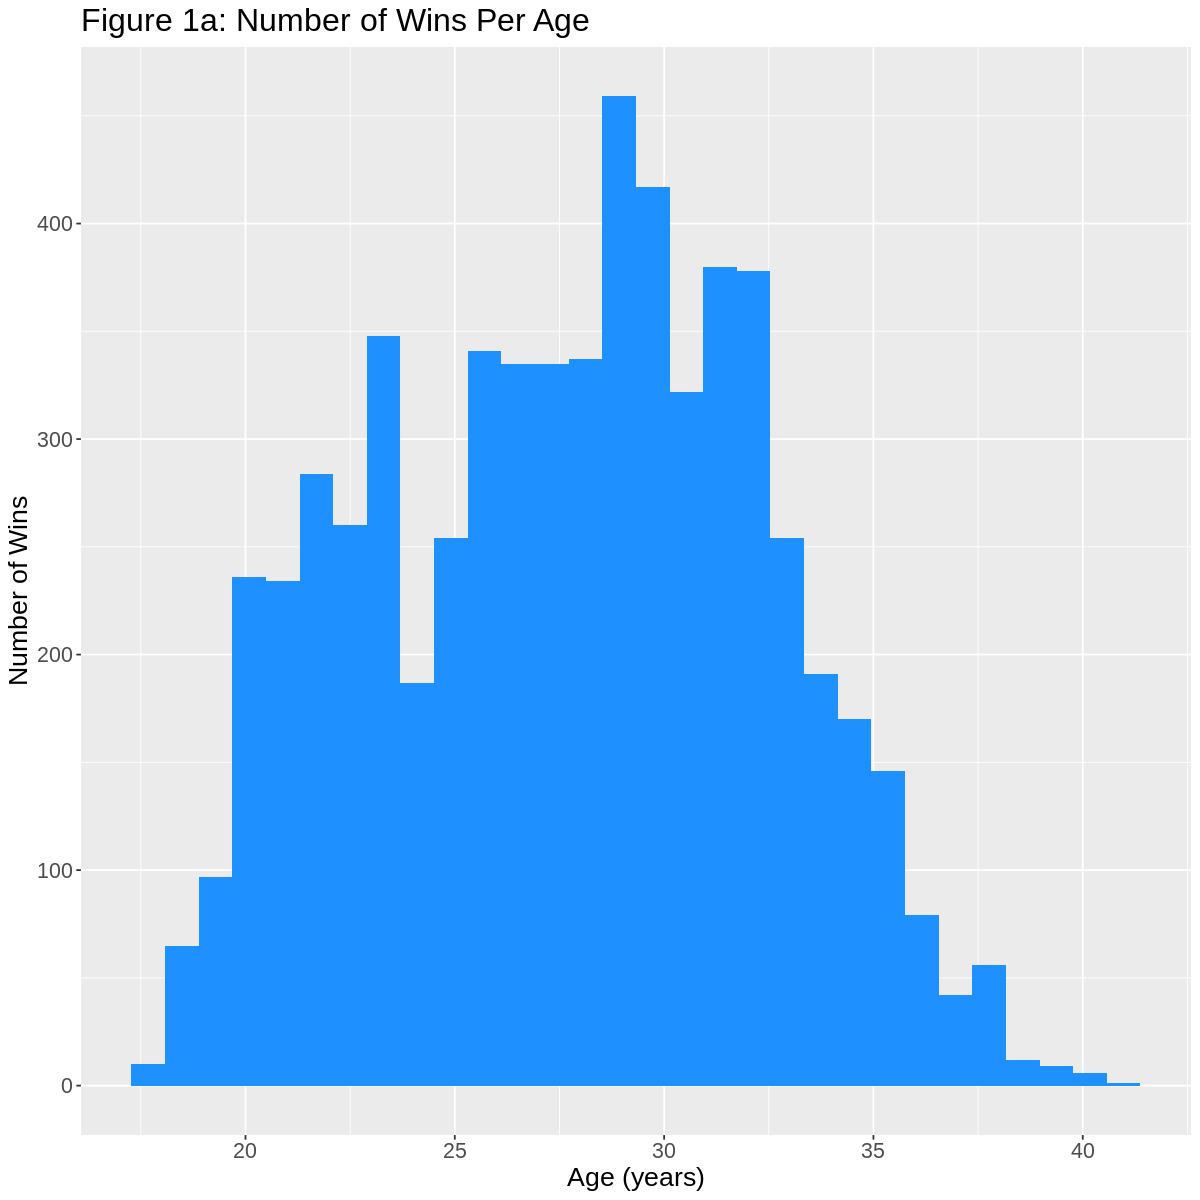

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 307 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


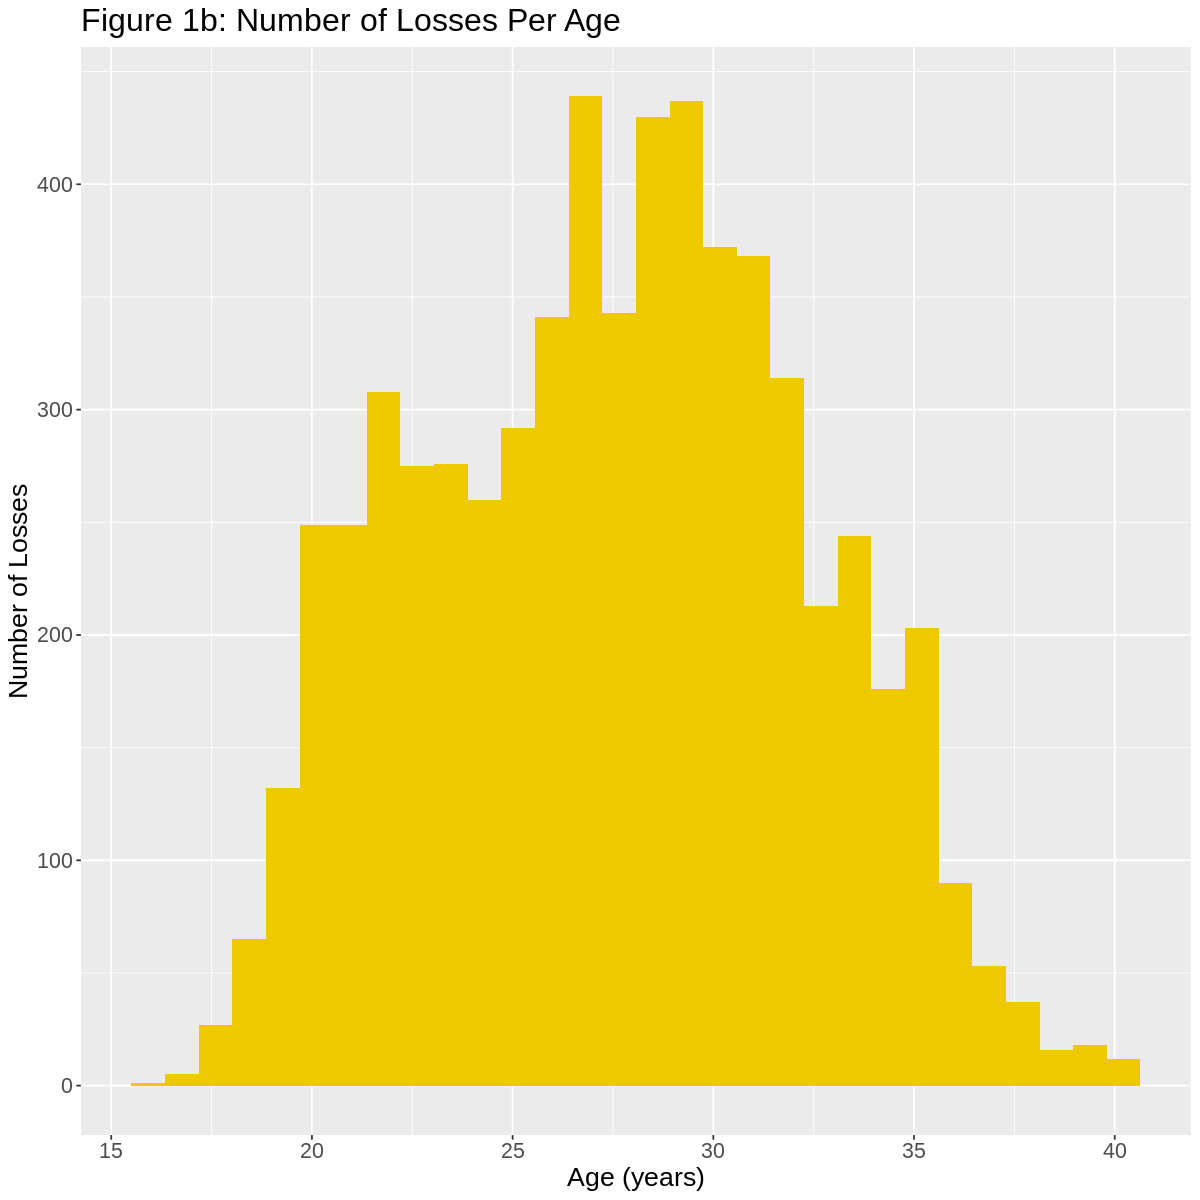

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 608 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


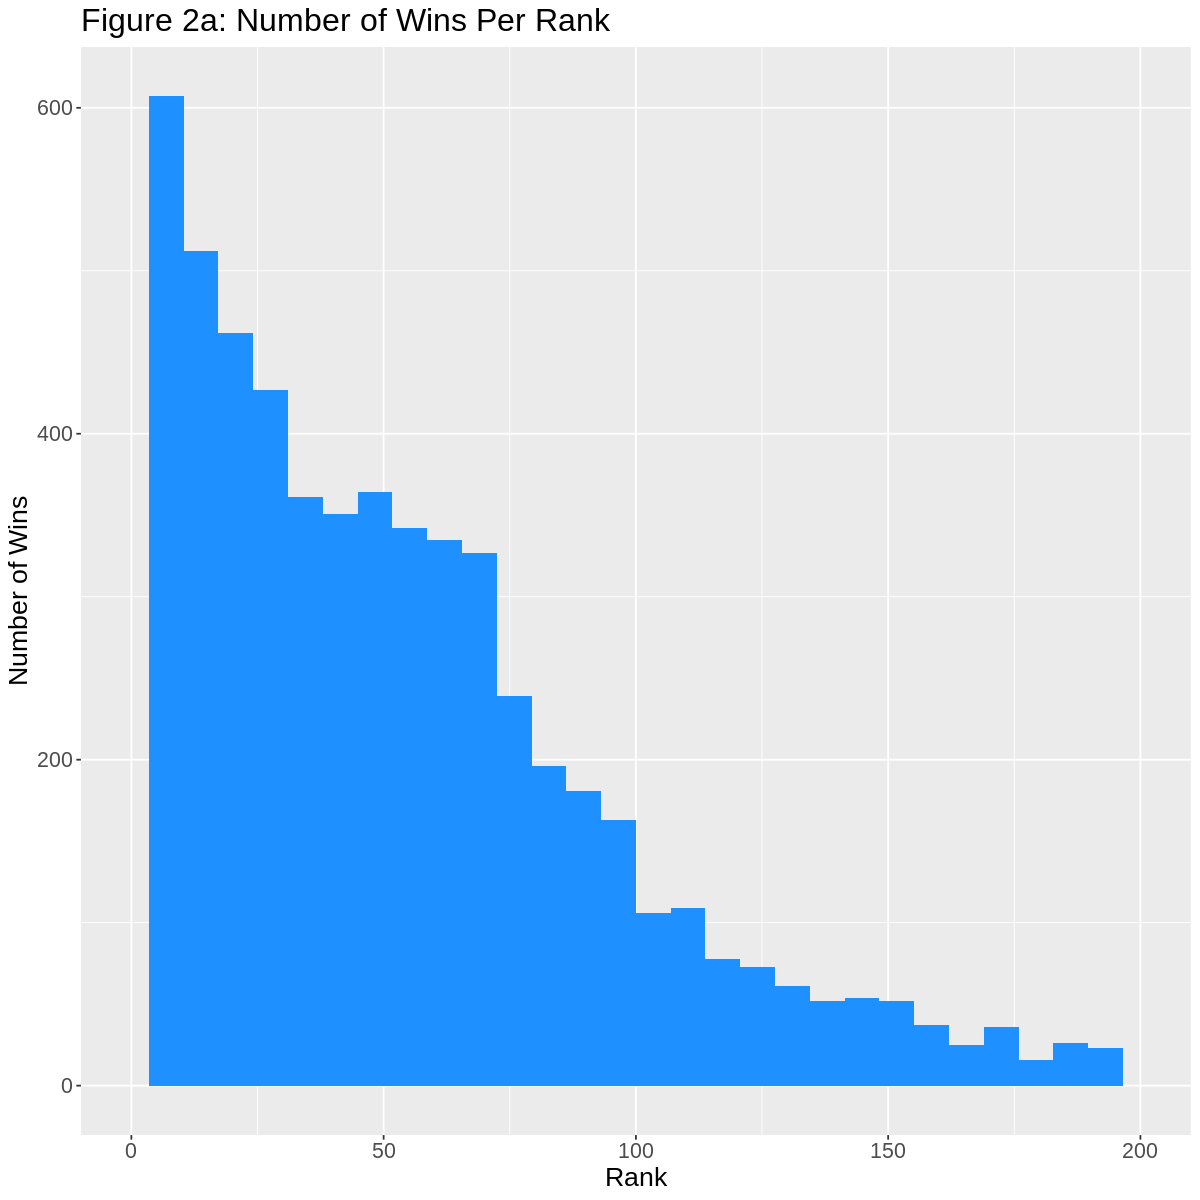

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 8 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


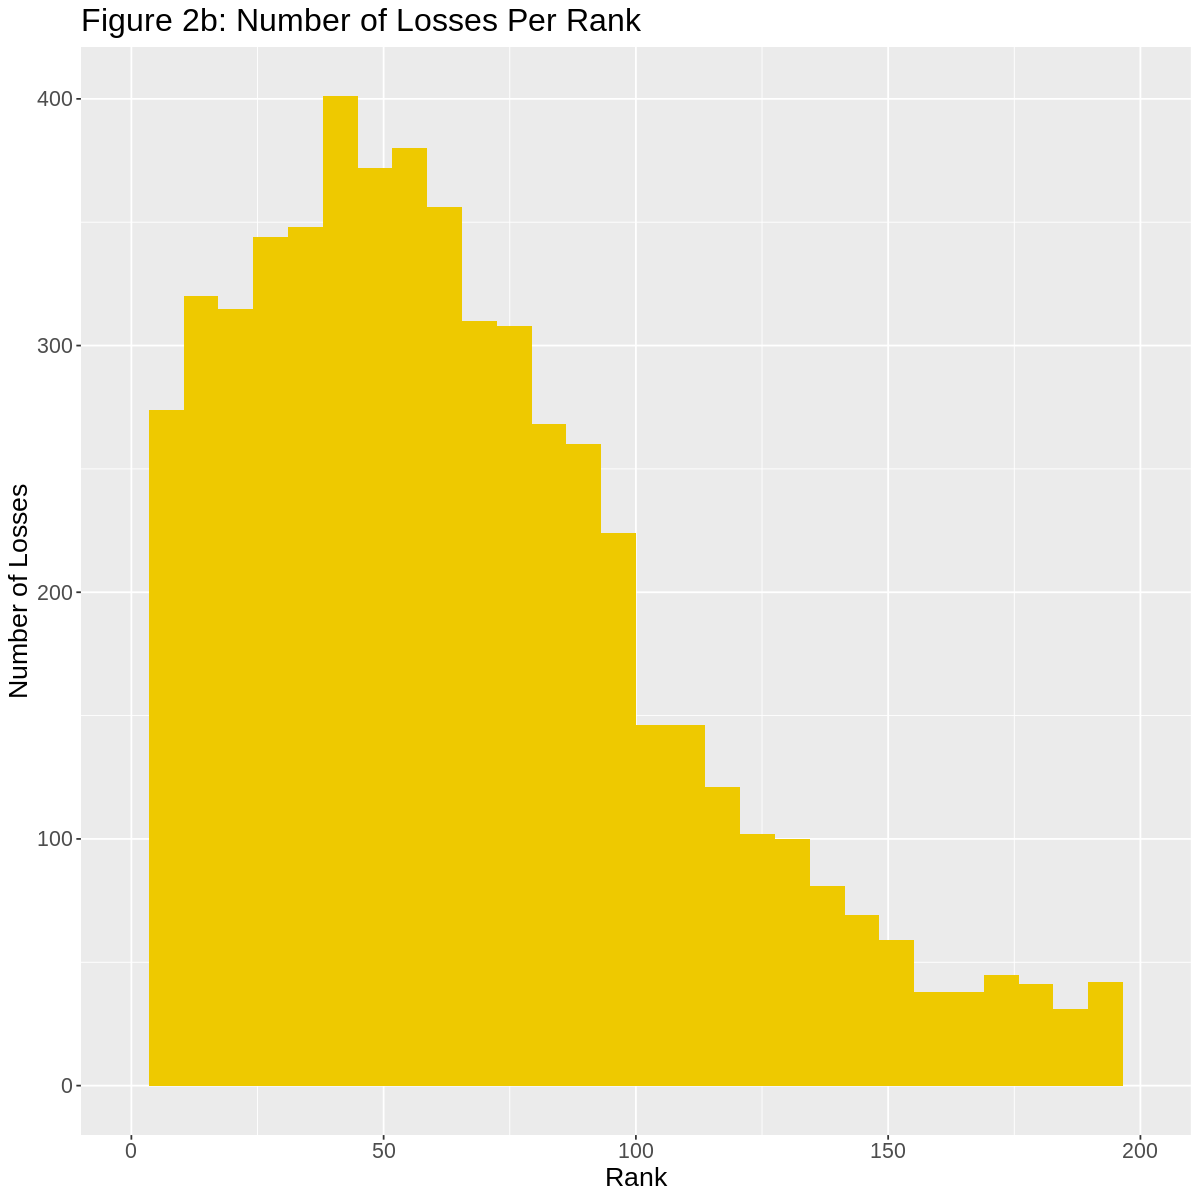

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 7 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


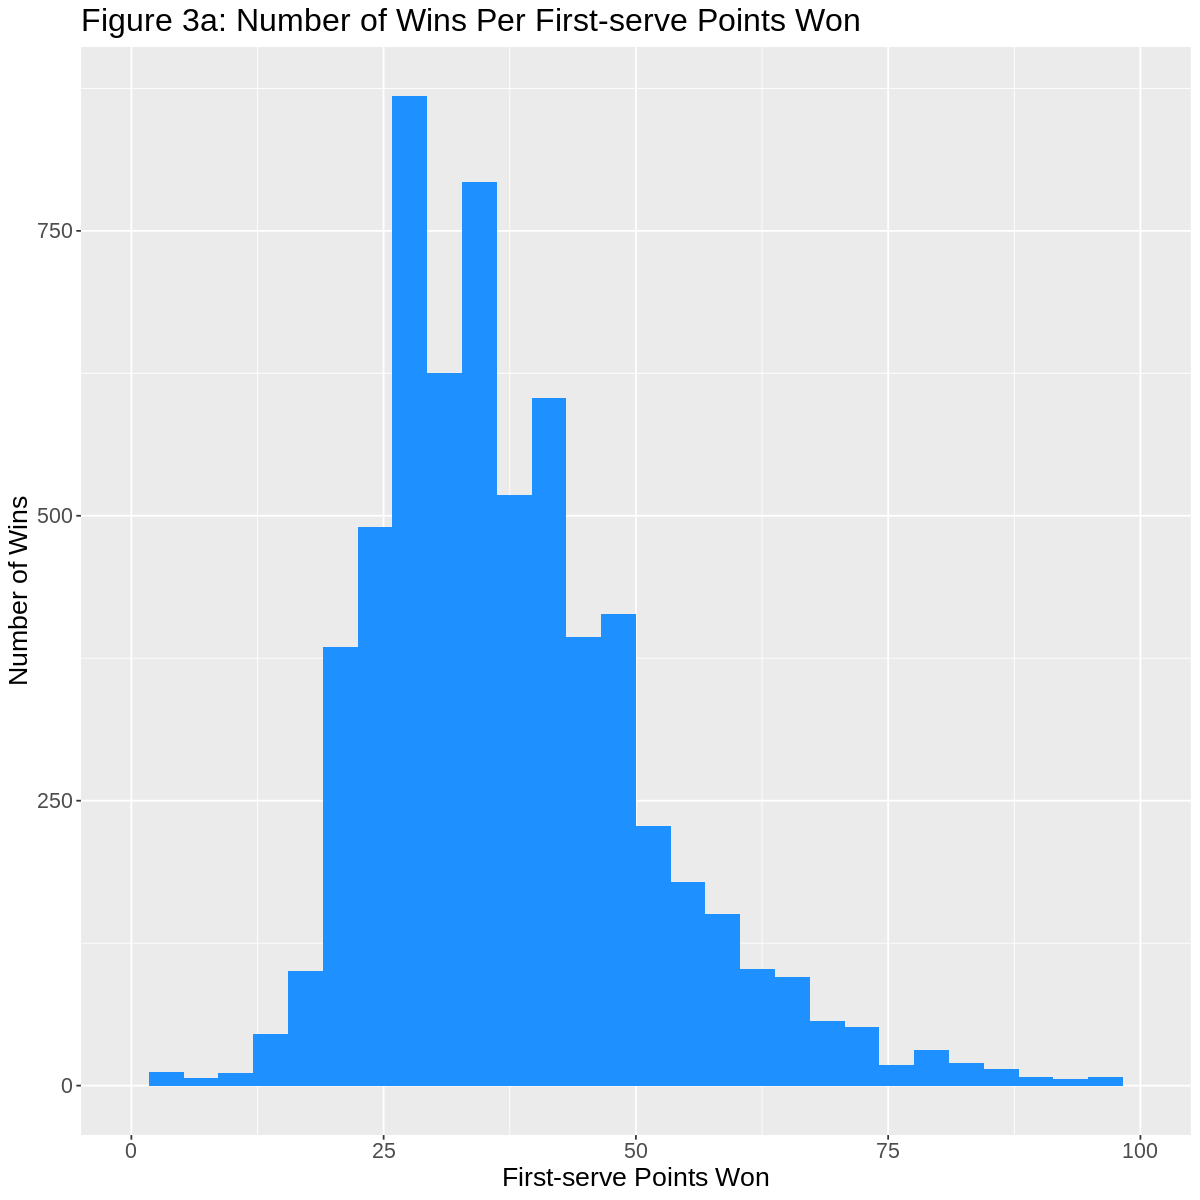

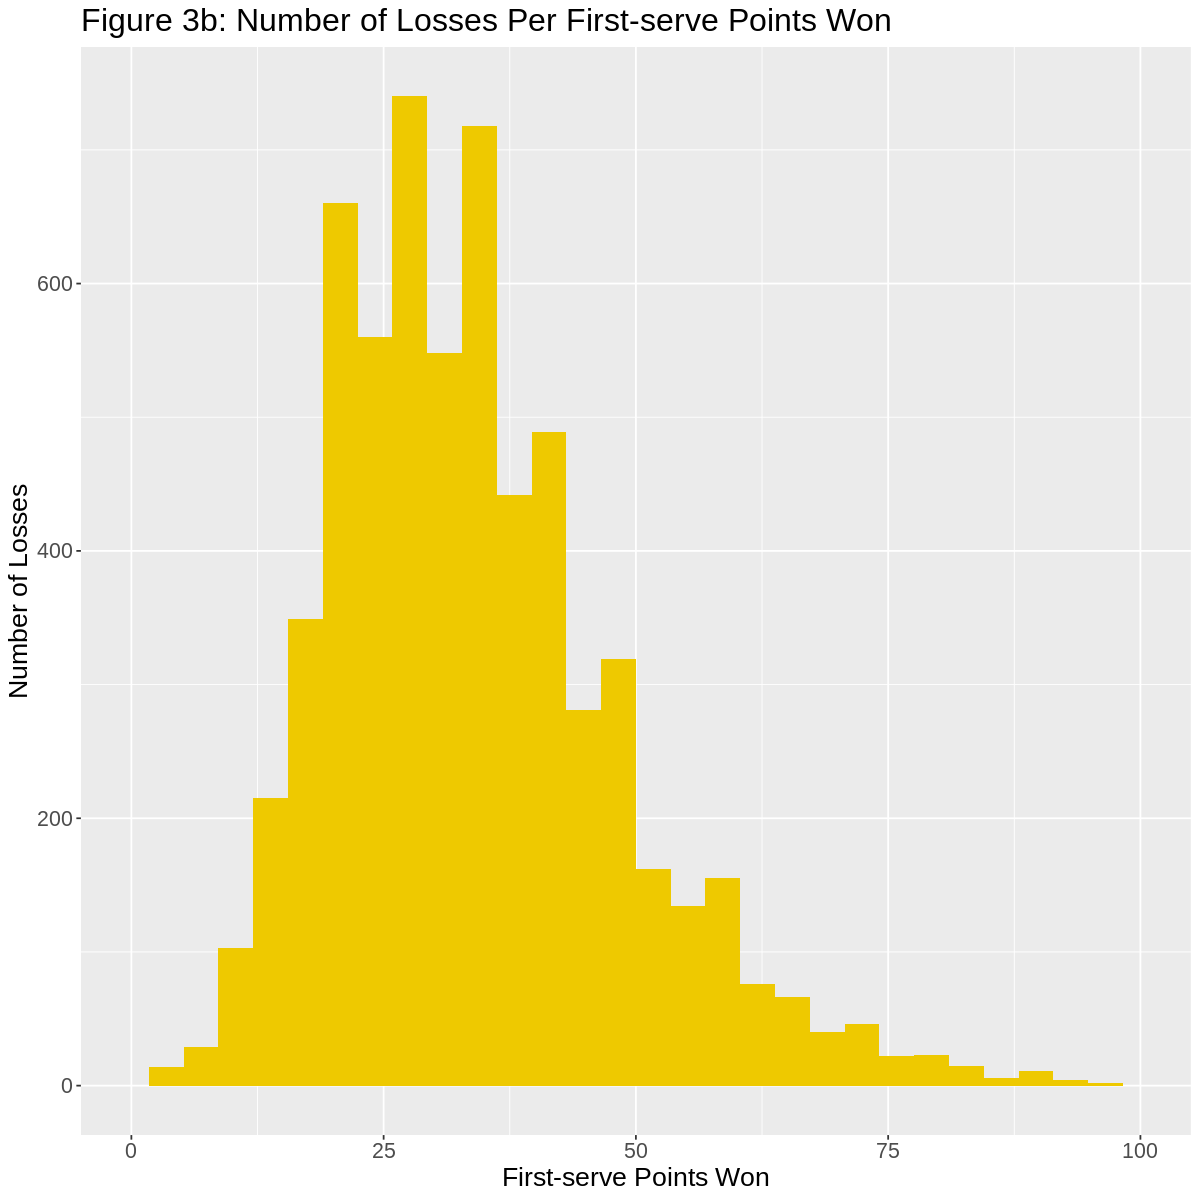

In [4]:
# Visualization of dataset - Code

options(repr.plot.height = 10, repr.plot.width = 10)

# Predictor 1 (Age) vs Result

atp_train_wins <- filter(atp_train, result == "win")

wins_per_age <- ggplot(atp_train_wins, aes(x = age)) +
                   geom_histogram(fill = "dodgerblue") +
                   labs(x = "Age (years)", y = "Number of Wins") +
                   ggtitle("Figure 1a: Number of Wins Per Age") +
                   theme(text = element_text(size = 16))
                   
wins_per_age

atp_train_losses <- filter(atp_train, result == "lose")


losses_per_age <-  ggplot(atp_train_losses, aes(x = age)) +
                   geom_histogram(fill = "gold2") +
                   labs(x = "Age (years)", y = "Number of Losses") +
                   ggtitle("Figure 1b: Number of Losses Per Age") +
                   theme(text = element_text(size = 16))

losses_per_age


# Predictor 2 (Rank) vs Result

wins_per_rank <- ggplot(atp_train_wins, aes(x = rank)) +
                   geom_histogram(fill = "dodgerblue") +
                   labs(x = "Rank", y = "Number of Wins") +
                   xlim(0,200) +
                   ggtitle("Figure 2a: Number of Wins Per Rank") +
                   theme(text = element_text(size = 16))
                   
wins_per_rank


losses_per_rank <-  ggplot(atp_train_losses, aes(x = rank)) +
                   geom_histogram(fill = "gold2") +
                   labs(x = "Rank", y = "Number of Losses") +
                   xlim(0,200) +
                   ggtitle("Figure 2b: Number of Losses Per Rank") +
                   theme(text = element_text(size = 16))               

losses_per_rank


# Predictor 3 (First-serve points Won) vs Result

wins_per_1stwon <- ggplot(atp_train_wins, aes(x = first_svpt_won)) +
                   geom_histogram(fill = "dodgerblue") +
                   labs(x = "First-serve Points Won", y = "Number of Wins") +
                   xlim(0,100) +
                   ggtitle("Figure 3a: Number of Wins Per First-serve Points Won") +
                   theme(text = element_text(size = 16))

wins_per_1stwon


losses_per_1stwon <- ggplot(atp_train_losses, aes(x = first_svpt_won)) +
                   geom_histogram(fill = "gold2") +
                   labs(x = "First-serve Points Won", y = "Number of Losses") +
                   xlim(0,100) +
                   ggtitle("Figure 3b: Number of Losses Per First-serve Points Won") +
                   theme(text = element_text(size = 16))

losses_per_1stwon


Figure 1a and 1b indicates a reduction of wins for players around 24 to 25 years old, and 29 year old players contribute the most wins. Also, 36.25 to 38 year-old players have double the amount of wins than losses. Figures 2a and 2b show players ranked in the top 25 have a significantly higher number of wins than losses while players ranked from 100 onwards had significantly more losses than wins. From Table 1, the average rank of the winner is also higher than the player that loses. In Figure 3a and 3b, higher first-serve points won relates to more number of wins than losses, especially after 37 points. Winners of matches also have a higher average first-serve point than losers of the match as shown in Table 1. Thus, rank and first-serve points will serve as stronger predictors and the age predictor could help differentiate when the other two predictors have similar values.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 307 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 608 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


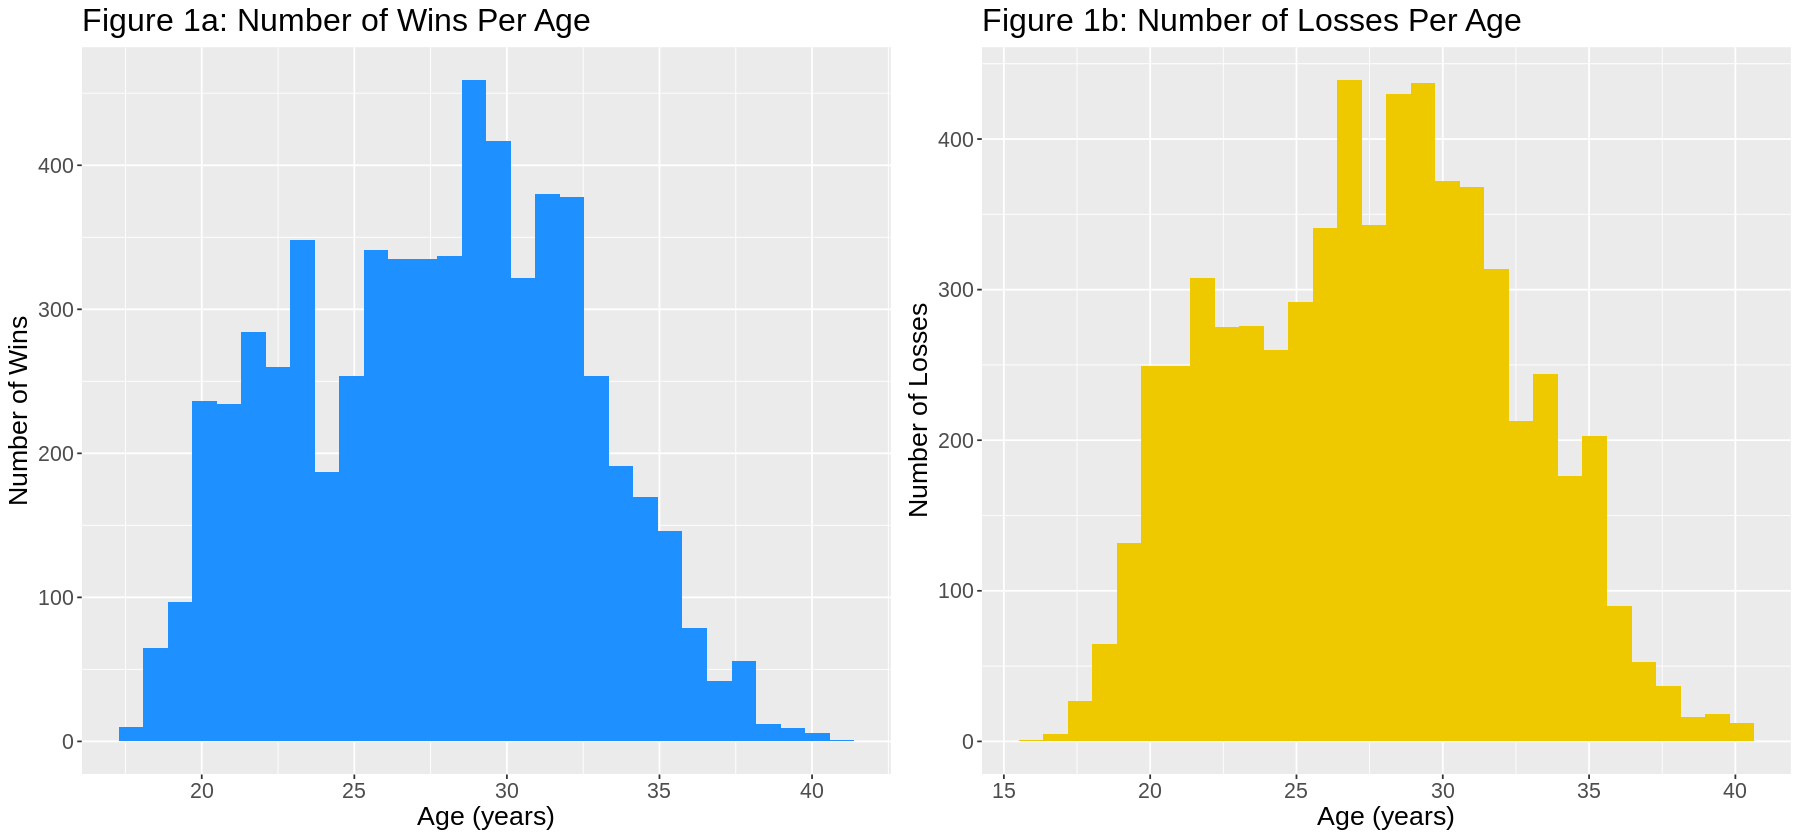

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 8 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 7 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


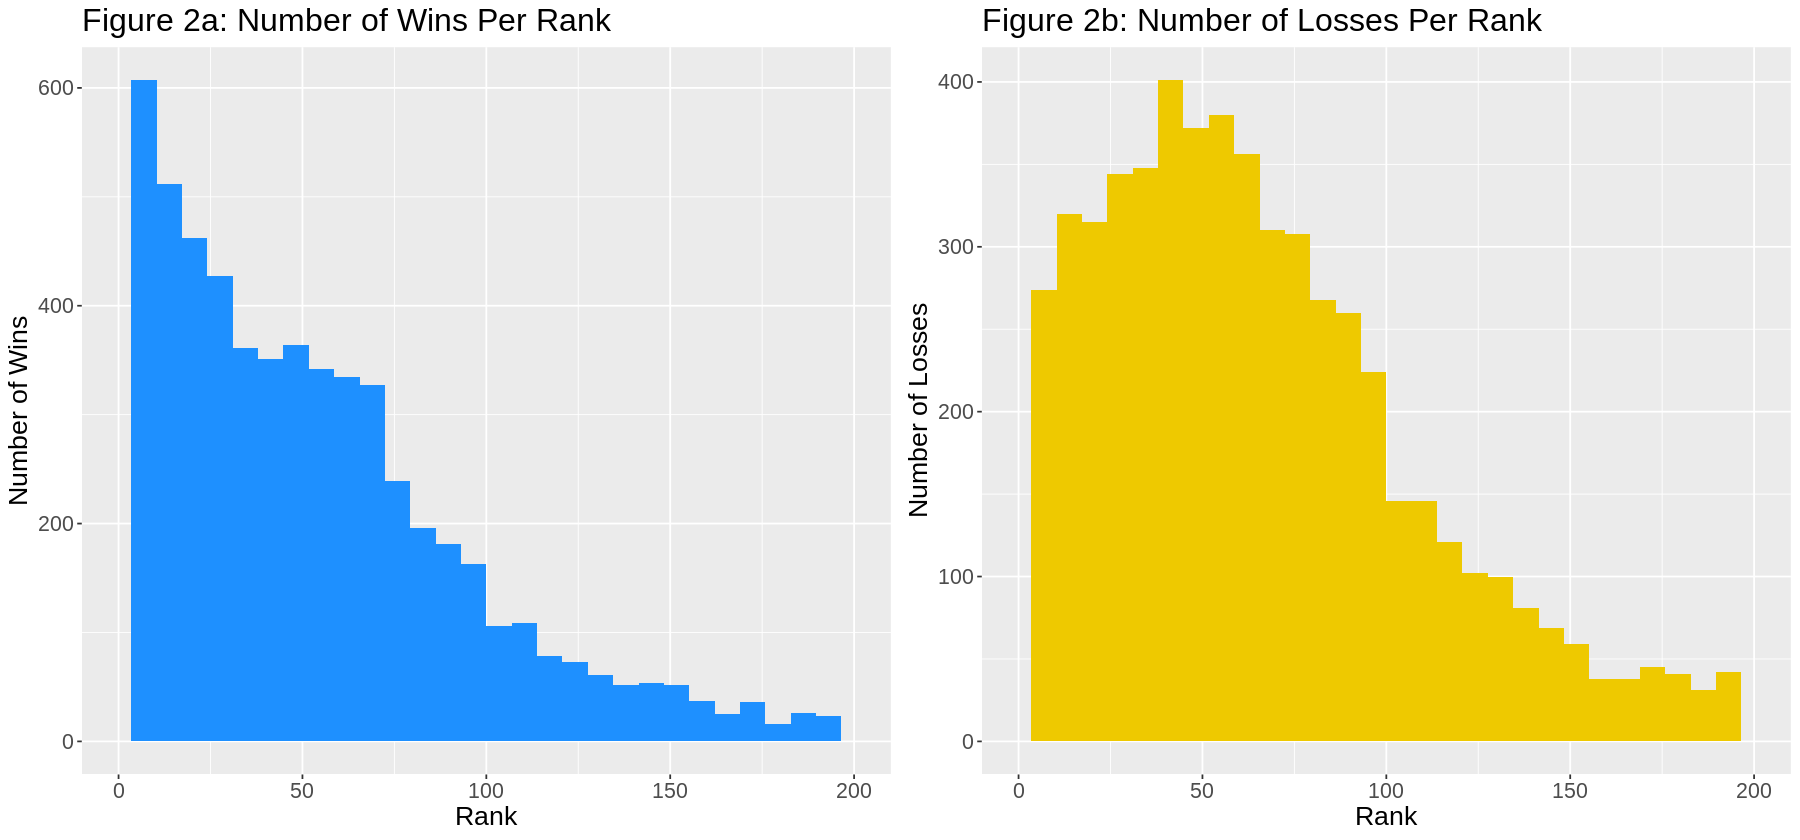

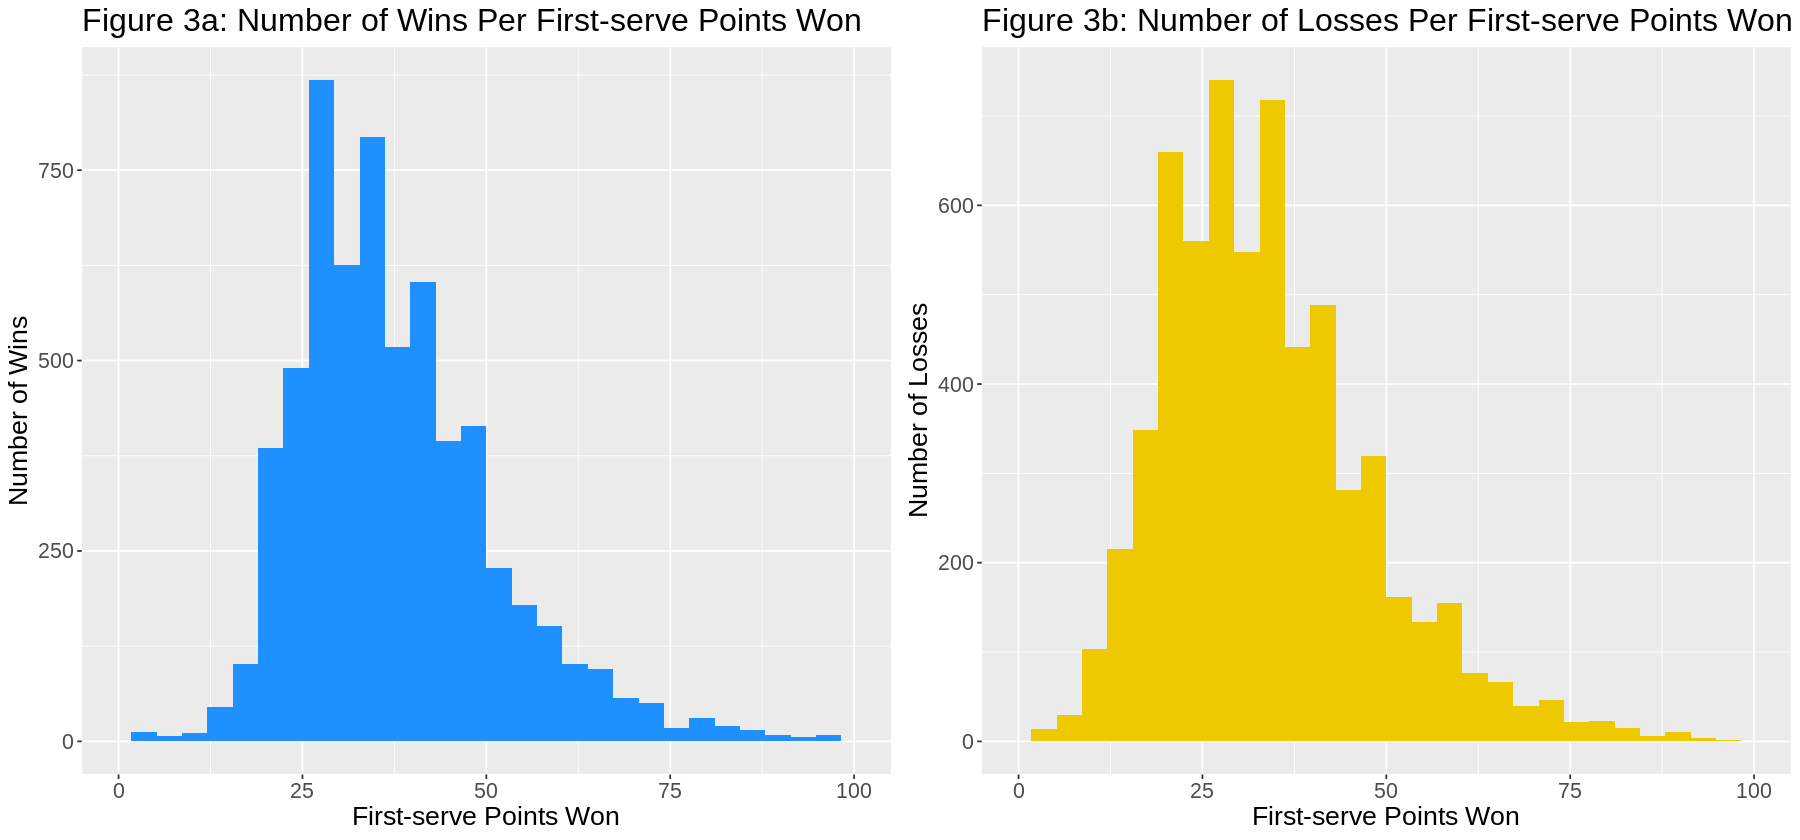

In [13]:
options(repr.plot.width = 15, repr.plot.height = 7)
plot_grid(wins_per_age, losses_per_age, ncol = 2)
plot_grid(wins_per_rank, losses_per_rank, ncol = 2)
plot_grid(wins_per_1stwon, losses_per_1stwon, ncol = 2)

In [10]:
atp_vfold <- vfold_cv(atp_train, v = 10, strata = result)

atp_recipe <- recipe(result ~ age + rank + first_svpt_won, data = atp_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")


In [19]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
  add_recipe(atp_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = atp_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5323429,10,0.005485336,Preprocessor1_Model01
6,accuracy,binary,0.5662108,10,0.003661443,Preprocessor1_Model02
11,accuracy,binary,0.5787045,10,0.002893033,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,accuracy,binary,0.5926341,10,0.002650859,Preprocessor1_Model18
91,accuracy,binary,0.5923155,10,0.002958350,Preprocessor1_Model19
96,accuracy,binary,0.5927949,10,0.002758541,Preprocessor1_Model20


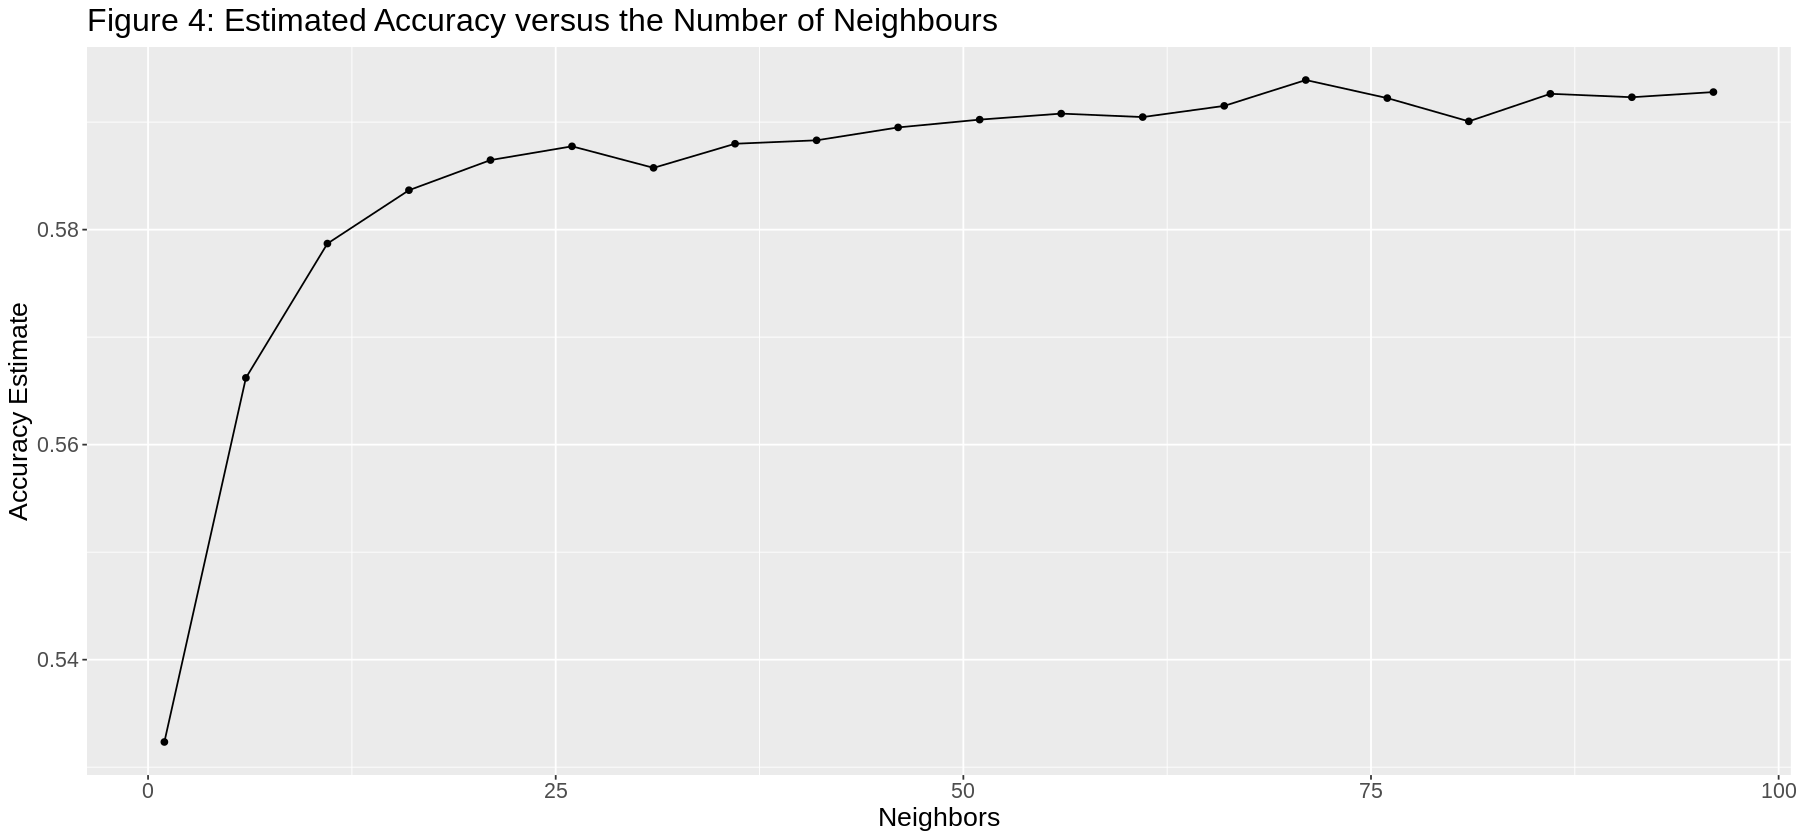

In [20]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  ggtitle("Figure 4: Estimated Accuracy versus the Number of Neighbours") +
  theme(text = element_text(size = 16))

accuracy_vs_k

In [21]:
atp_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 71) |>
            set_engine("kknn") |>
            set_mode("classification")

atp_fit <- workflow() |>
           add_recipe(atp_recipe) |>
           add_model(atp_spec) |>
           fit(data = atp_train)


In [22]:
atp_predictions <- predict(atp_fit, atp_test) |>
     bind_cols(atp_test)

atp_metrics <- atp_predictions |>
     metrics(truth = result, estimate = .pred_class)

atp_predictions

atp_metrics

.pred_class,result,age,rank,first_svpt_won
<fct>,<fct>,<dbl>,<dbl>,<dbl>
win,win,22.7,79,26
win,win,34.9,39,42
win,win,26.0,3,30
⋮,⋮,⋮,⋮,⋮
lose,lose,20.3,194,14
win,lose,21.7,47,30
lose,lose,20.1,60,20


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.598463
kap,binary,0.196926


In [23]:
atp_conf_mat <- atp_predictions |>
     conf_mat(truth = result, estimate = .pred_class)

atp_conf_mat

          Truth
Prediction  win lose
      win  1367  957
      lose  715 1125

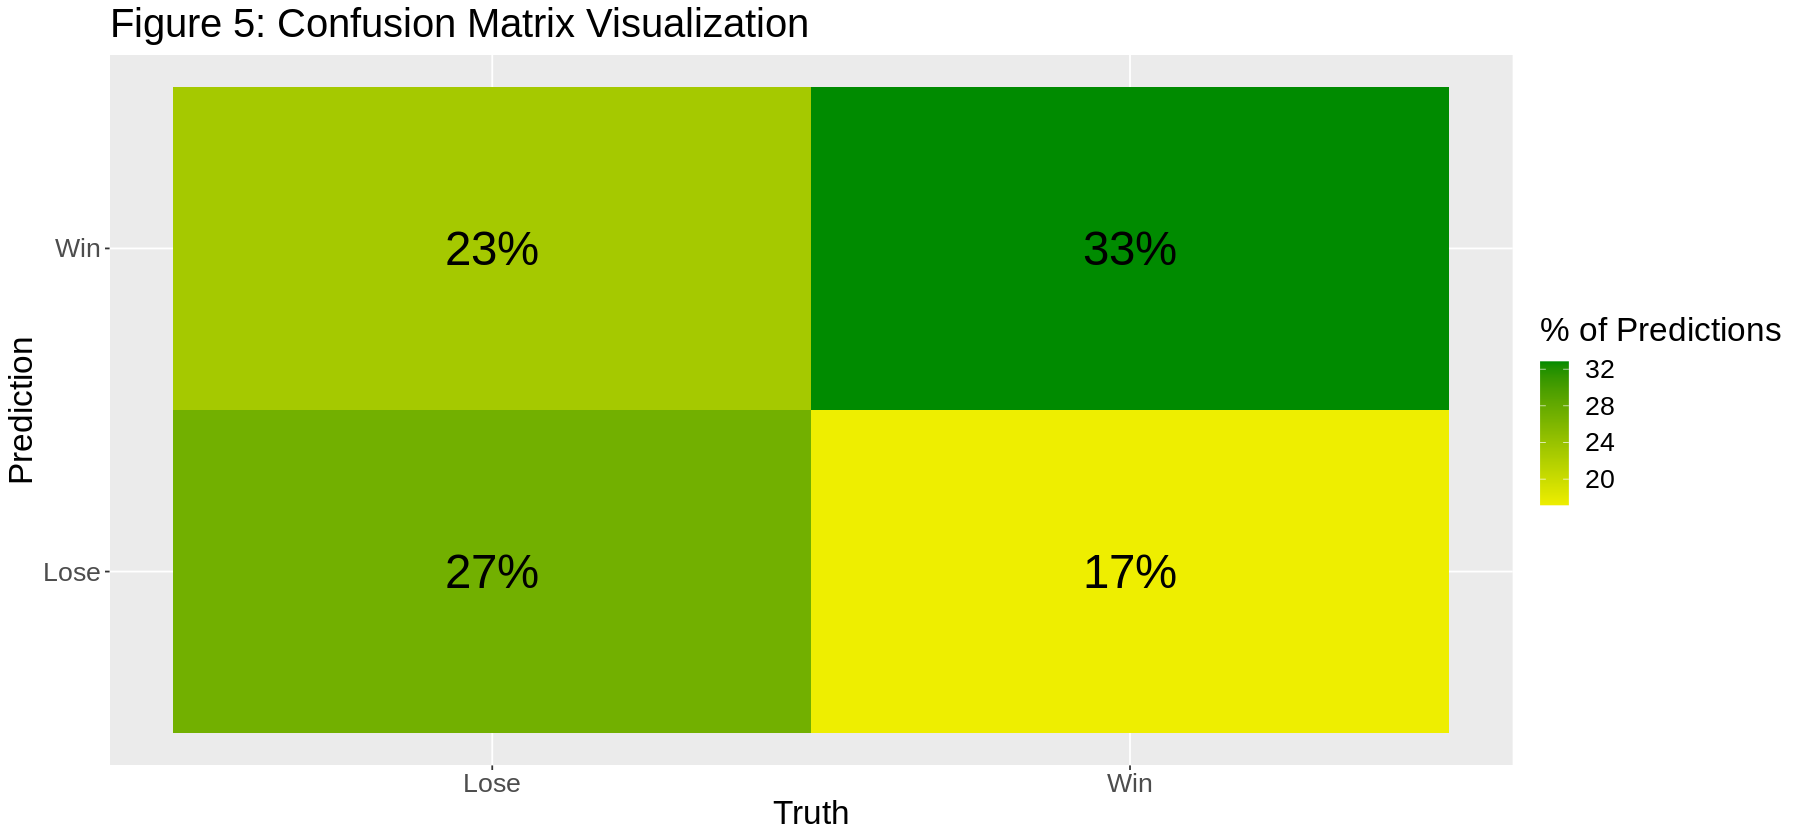

In [24]:
Prediction <- as.factor(c("Win", "Lose", "Win", "Lose"))
Truth <- as.factor(c("Win", "Win","Lose", "Lose"))
outcome <- c((1367/4164)*100, (715/4164) * 100, (957/4164) * 100, (1125/4164) * 100)

conf_mat_data <- as_tibble(Truth, Prediction, outcome)


ggplot(data = conf_mat_data, mapping = aes(x = Truth, y = Prediction)) +
geom_tile(aes(fill = outcome)) +
scale_fill_gradient(low = "yellow2", high = "green4") +
geom_text(aes(label = str_c(round(outcome), "%")), size = 10) +
ggtitle("Figure 5: Confusion Matrix Visualization") +
labs(fill = "% of Predictions") +
theme(text = element_text(size = 20))


## Discussion

#### What did we find?
For ages, although the average for wins and losses are fairly the same, the distribution is slightly different. While most players ranked top 200 were aged 26-32.5, the age distribution among winners is narrower than that of losers, and those aged 33 or above had more losses than wins. For ranks, players ranked in the top 25 have a significantly higher number of wins than losses, while the number of losses is more likely contributed by players that rank beyond 50, and losses are continued to be greater than wins for lower ranks. For getting the 1st serve point, higher first-serve point contributes to higher chance of winning, as players getting first-serve points below 25 have more losses than wins, white those getting above 40 have more wins than losses, making a noticeable shift of lower first-serve points causes less wins.

#### Is the result aligned with what we expected?
The results are aligned with the expected outcomes. About age, research was conducted that athletes reached their peaks at the age of 25-30, as muscle endurance and strength started to decline after 30s, but sufficient training may have a prolonged effect on ageing `2`; however, young age isn’t completely beneficial for players due to lack of skills and insufficient training. About ranks, they were based on ATP/WTA rank as of tournament date, which has significant impact as ranks varied a lot by their competition’s performance, with their previous record as reference, it became easier to predict the winner of a game. About first-serve, research suggests that getting higher first-serve points helps dictate the flow of tennis `3`, with better control of the game, players may have a better mentality when facing the opponent.

## References

‌Brycki, J. (2018, December 7). Game, set, match: How to price a tennis match. Pinnacle. Retrieved April 11, 2023, from https://www.pinnacle.com/en/betting-articles/Tennis/how-to-price-a-tennis-match/NBKJM2N7PJG4DNFJ 

Costello, N. (2020, February 4). What age do athletes peak? Built for Athletes. Retrieved April 11, 2023, from https://builtforathletes.com/blogs/news/what-age-do-athletes-peak.

Mirpuri, S. (2021, March 15). How important is the serve in men's singles tennis? Bruin Sports Analytics. Retrieved April 11, 2023, from https://www.bruinsportsanalytics.com/post/serve_importance 

Sackmann, J. (2020, March 13). JeffSackmann/tennis_atp: ATP Tennis Rankings, Results, and Stats. GitHub. Retrieved February 28, 2023, from https://github.com/JeffSackmann/tennis_atp  

United States Tennis Association. (n.d.). Scoring Points & Tennis Sets. USTA. Retrieved April 10, 2023, from https://www.usta.com/en/home/improve/tips-and-instruction/national/tennis-scoring-rules.html

Yue, J. C., Chou, E. P., Hsieh, M.-H., & Hsiao, L.-C. (2022, April 8). A study of forecasting tennis matches via the Glicko model. National Library of Medicine. Retrieved April 11, 2023, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8992979/